## Initial setup
This analysis using ema is based on the work of Enayat A. Moallemi created on 22 May 2018 at the Fraunhofer ISI, Karlsruhe. In that instance, the analysis was done for the MATISSE model.
This notebook present a second stage on a SA and UA. It is a variance-based approach using the SOBOL. 
For this, The EMA workbench is used with SALib SOBOL sampler and SALib analyse methods.
    

In [1]:

'''
by Angela M. Rojas A. <angelara@student.unimelb.edu.au>

Created on February 2020

'''
import sys
import os

sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\EMAworkbench')

sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import seaborn as sns
import os
import glob
import numpy as np
import pandas as pd
import os
import glob

includePlots = True

## SOBOL visualization functions
source code from [here](https://pynetlogo.readthedocs.io/en/latest/_docs/SALib_ipyparallel.html) code-block 25

In [84]:
import itertools
from math import pi


def normalize(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)


def plot_circles(ax, locs, names, max_s, stats, smax, smin, fc, ec, lw,
                 zorder):
    s = np.asarray([stats[name] for name in names])
    s = 0.01 + max_s * np.sqrt(normalize(s, smin, smax))

    fill = True
    for loc, name, si in zip(locs, names, s):
        if fc=='w':
            fill=False
        else:
            ec='none'

        x = np.cos(loc)
        y = np.sin(loc)

        circle = plt.Circle((x,y), radius=si, ec=ec, fc=fc, transform=ax.transData._b,
                            zorder=zorder, lw=lw, fill=True)
        ax.add_artist(circle)


def filter(sobol_indices, names, locs, criterion, threshold):
    if criterion in ['ST', 'S1', 'S2']:
        data = sobol_indices[criterion]
        data = np.abs(data)
        data = data.flatten() # flatten in case of S2
        # TODO:: remove nans

        filtered = ([(name, locs[i]) for i, name in enumerate(names) if
                     data[i]>threshold])
        filtered_names, filtered_locs = zip(*filtered)
    elif criterion in ['ST_conf', 'S1_conf', 'S2_conf']:
        raise NotImplementedError
    else:
        raise ValueError('unknown value for criterion')

    return filtered_names, filtered_locs


def plot_sobol_indices(sobol_indices, uncertainties, criterion='ST', threshold=0.01):
    '''plot sobol indices on a radial plot

    Parameters
    ----------
    sobol_indices : dict
                    the return from SAlib
    criterion : {'ST', 'S1', 'S2', 'ST_conf', 'S1_conf', 'S2_conf'}, optional
    threshold : float
                only visualize variables with criterion larger than cutoff

    '''
    max_linewidth_s2 = 15 #25*1.8
    max_s_radius = 0.3

    # prepare data
    # use the absolute values of all the indices
    #sobol_indices = {key:np.abs(stats) for key, stats in sobol_indices.items()}

    # dataframe with ST and S1
    sobol_stats = {key:sobol_indices[key] for key in ['ST', 'S1']}
    sobol_stats = pd.DataFrame(sobol_stats, index=uncertainties)

    smax = sobol_stats.max().max()
    smin = sobol_stats.min().min()

    # dataframe with s2
    s2 = pd.DataFrame(sobol_indices['S2'], index=uncertainties,
                      columns=uncertainties)
    s2[s2<0.0]=0. #Set negative values to 0 (artifact from small sample sizes)
    s2max = s2.max().max()
    s2min = s2.min().min()

    names = uncertainties
    n = len(names)
    ticklocs = np.linspace(0, 2*pi, n+1)
    locs = ticklocs[0:-1]

    filtered_names, filtered_locs = filter(sobol_indices, names, locs,
                                           criterion, threshold)

    # setup figure
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    ax.set_xticks(ticklocs)

    ax.set_xticklabels(names)
    ax.set_yticklabels([])
    ax.set_ylim(top=1.4)
    legend(ax)

    # plot ST
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['ST'], smax, smin, 'w', 'k', 1, 9)

    # plot S1
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['S1'], smax, smin, 'k', 'k', 1, 10)

    # plot S2
    for name1, name2 in itertools.combinations(zip(filtered_names, filtered_locs), 2):
        name1, loc1 = name1
        name2, loc2 = name2

        weight = s2.loc[name1, name2]
        lw = 0.5+max_linewidth_s2*normalize(weight, s2min, s2max)
        ax.plot([loc1, loc2], [1,1], c='darkgray', lw=lw, zorder=1)

    return fig


from matplotlib.legend_handler import HandlerPatch
class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = plt.Circle(xy=center, radius=orig_handle.radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

def legend(ax):
    some_identifiers = [plt.Circle((0,0), radius=5, color='k', fill=False, lw=1),
                        plt.Circle((0,0), radius=5, color='k', fill=True),
                        plt.Line2D([0,0.5], [0,0.5], lw=8, color='darkgray')]
    ax.legend(some_identifiers, ['ST', 'S1', 'S2'],
              loc='lower center', bbox_to_anchor=(1, 1), borderaxespad=0.1, mode='expand',
              handler_map={plt.Circle: HandlerCircle()})

## Load the results
These results are a tuple of one data frame with the changes on each input variable, and a dictionary with the outputs. 

In [3]:
from ema_workbench import load_results

#results = load_results(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/simulationData/gr4sp_2020-Aug-22-SOBOL.tar.gz')
#results = load_results(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/simulationData/gr4sp_SOBOL2020-Oct-07.tar.gz')
results = load_results(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/simulationData/gr4sp_SOBOL2020ABY-Dec-23.tar.gz')


In [4]:
experiments, outcomes = results

# Create a temporary copy of dictionary, with Outcomes Year
outcomesYear = dict(outcomes)

keysToRemove = [] 
# Iterate over the temporary dictionary and delete corresponding key from original dictionary
for (key, value) in outcomesYear.items() :
    if 'Month' in key:
        keysToRemove.append(key)
        
for k in keysToRemove:        
    del outcomesYear[k]   
    
        

In [5]:
experiments.describe()

,annualInflation,consumption,domesticConsumptionPercentage,generationRolloutPeriod,generatorRetirement,importPriceFactor,includePublicallyAnnouncedGen,learningCurve,nameplateCapacityChangeBattery,nameplateCapacityChangeBrownCoal,...,priceChangePercentageBattery,priceChangePercentageBrownCoal,priceChangePercentageOcgt,priceChangePercentageWater,priceChangePercentageWind,scheduleMinCapMarketGen,semiScheduleGenSpotMarket,semiScheduleMinCapMarketGen,solarUptake,wholesaleTariffContribution
count,113400.000000,113400.000000,113400.000000,113400.000000,113400.000000,113400.000000,113400.000000,113400.000000,113400.000000,113400.000000,...,113400.000000,113400.000000,113400.000000,113400.000000,113400.000000,113400.000000,113400.000000,113400.000000,113400.000000,113400.000000
mean,2.998333,1.999286,34.995000,5.499524,0.001429,-0.036429,0.500000,7.498095,-0.011667,-0.003810,...,0.018333,0.008810,0.037381,-0.001190,0.020952,150.493333,9.000238,150.448571,2.000952,27.480952
std,1.415313,1.415145,8.943764,2.872045,3.160559,29.154771,0.500002,4.609792,29.153028,29.152936,...,29.154641,29.154997,29.155317,29.153079,29.153410,86.593703,0.816354,86.600809,1.415229,10.387590
min,1.000000,0.000000,20.000000,1.000000,-5.000000,-50.000000,0.000000,0.000000,-50.000000,-50.000000,...,-50.000000,-50.000000,-50.000000,-50.000000,-50.000000,1.000000,8.000000,1.000000,0.000000,10.000000
25%,2.000000,1.000000,27.000000,3.000000,-3.000000,-25.000000,0.000000,3.750000,-25.000000,-25.000000,...,-25.000000,-25.000000,-25.000000,-25.000000,-25.000000,75.750000,8.000000,75.750000,1.000000,18.750000
50%,3.000000,2.000000,35.000000,5.500000,0.000000,0.000000,0.500000,7.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,150.500000,9.000000,150.500000,2.000000,27.500000
75%,4.000000,3.000000,43.000000,8.000000,3.000000,25.000000,1.000000,11.250000,25.000000,25.000000,...,25.000000,25.000000,25.000000,25.000000,25.000000,225.250000,10.000000,225.250000,3.000000,36.250000
max,5.000000,4.000000,50.000000,10.000000,5.000000,50.000000,1.000000,15.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,300.000000,10.000000,300.000000,4.000000,45.000000


## Uncertainties/levers

The outcomes are shown per year. Though another analysis can be done for monthly outcomes. 

In [101]:
outcomes_to_show = ['consumptionYear', 'tariffsYear', 'wholesalePriceYear', 'GHGYear', 
                    'primarySpotProductionYear', 'secondarySpotProductionYear', 
                    'offSpotProductionYear', 'renewableContributionYear', 'rooftopPVProductionYear', 
                    'coalProductionYear', 'waterProductionYear', 'windProductionYear', 'gasProductionYear', 
                    'solarProductionYear', 'primaryUnmetDemandMwh', 
                    'primaryUnmetDemandHours', 'primaryUnmetDemandDays', 'primaryMaxUnmetDemandMwhPerHour', 
                    'secondaryUnmetDemandMwh', 'secondaryUnmetDemandHours', 'secondaryUnmetDemandDays', 
                    'secondaryMaxUnmetDemandMwhPerHour']


# 23 levers/uncertainties selected after EET (last test July 2020)
# 25 uncertainties selected aftet EET including change on domestic demand and unmet demand output (August 2020)
# 26 uncertainties selected after EET for changes afterBaseYear(Dec 2020)
uncertainties = experiments.columns[:-3]

#from startYear
startYear = 2019
startYearShift = (startYear - 1998)
#startYearShift = (startYear - 1997) * 12
time = outcomes['TIMEYear'][0, startYearShift:]
#index = pd.to_datetime(time, format = '%Y-%m-%d')
index = pd.to_datetime(time, format = '%Y')

In [102]:
for n in uncertainties:
    var = experiments[n]
    val = np.unique(var)
    print("{}: {}".format(n,val))

annualInflation: [1. 2. 3. 4. 5.]
consumption: [0. 1. 2. 3. 4.]
domesticConsumptionPercentage: [20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50.]
generationRolloutPeriod: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
generatorRetirement: [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
importPriceFactor: [-50. -49. -48. -47. -46. -45. -44. -43. -42. -41. -40. -39. -38. -37.
 -36. -35. -34. -33. -32. -31. -30. -29. -28. -27. -26. -25. -24. -23.
 -22. -21. -20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.
  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.
   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.
  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.
  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.
  48.  49.  50.]
includePublicallyAnnouncedGen: [0. 1.]
learningCurve: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 

## SOBOL
To obtain the SALib results for each input for the sobol sensitivity indices (S1, S2, and ST)

In [103]:
from gr4spModelSOBOL import getModelAFterBaseYear
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import determine_parameters
from EMAworkbench.ema_workbench import (IntegerParameter, RealParameter, CategoricalParameter, BooleanParameter)

model = getModelAFterBaseYear()
uncertaintyCategories = determine_parameters(model, 'uncertainties', union=False) 
problem = get_SALib_problem(uncertaintyCategories)

In [104]:
def isclose(a, b, rel_tol=1e-09):
    return abs(a-b) <= rel_tol 

from SALib.analyze import sobol

sobol_stats_years_ooi = {}
s1_years_ooi = {}
s1_conf_years_ooi = {}
st_years_ooi = {}
st_conf_years_ooi = {}
s2_years_ooi = {}
s2_conf_years_ooi = {}
num_uncertainties = len(uncertainties)
print(num_uncertainties)
for ooi in outcomes_to_show:
    sobol_stats_years = pd.DataFrame([],columns=uncertainties)
    s1_years = pd.DataFrame([],columns=uncertainties)
    s1_conf_years = pd.DataFrame([],columns=uncertainties)
    st_years = pd.DataFrame([],columns=uncertainties)
    st_conf_years = pd.DataFrame([],columns=uncertainties)
    s2_years = {}
    s2_conf_years = {}
    for t in range(startYearShift, startYearShift + len(time)):
        dataY = outcomes[ooi][:, t]
        #change num_uncertainties = p to do the analysis with p levels
        stdY = dataY.std()
        print("{} - std: {}".format(startYear+t, stdY ) )

        if isclose(stdY, 0.0, rel_tol=1e-9):
            sobol_indices = {}
            sobol_indices['ST'] = np.zeros( num_uncertainties )
            sobol_indices['ST_conf'] = np.zeros( num_uncertainties )
            sobol_indices['S1'] = np.zeros( num_uncertainties )
            sobol_indices['S1_conf'] = np.zeros( num_uncertainties )
            sobol_indices['S2'] = np.zeros( (num_uncertainties, num_uncertainties) )
            sobol_indices['S2_conf'] = np.zeros( (num_uncertainties, num_uncertainties) )
        else:
            sobol_indices = sobol.analyze(problem, dataY)
        
        sobol_stats = {key: sobol_indices[key] for key in ['ST', 'ST_conf', 'S1',
                                                       'S1_conf']}
        
        sobol_stats = pd.DataFrame(sobol_stats, index=uncertainties)
        sobol_stats.sort_values(by='ST', ascending=False)
        s1 = pd.DataFrame([sobol_indices['S1']], columns=uncertainties)
        s1_conf = pd.DataFrame([sobol_indices['S1_conf']], columns=uncertainties)
        st = pd.DataFrame([sobol_indices['ST']], columns=uncertainties)
        st_conf = pd.DataFrame([sobol_indices['ST_conf']], columns=uncertainties)
        s2 = pd.DataFrame(sobol_indices['S2'], index=uncertainties, columns=uncertainties)
        s2_conf = pd.DataFrame(sobol_indices['S2_conf'], columns=uncertainties)
        
        sobol_stats_years = sobol_stats_years.append(sobol_stats, sort=False)
        s1_years = s1_years.append(s1, sort=False)
        s1_conf_years = s1_conf_years.append(s1_conf, sort=False)
        st_years = st_years.append(st, sort=False)
        st_conf_years = st_conf_years.append(st_conf, sort=False)
        s2_years[startYear] = s2
        s2_conf_years[startYear+t] = s2_conf
    
    s1_years = s1_years.set_index(time)        
    s1_conf_years = s1_conf_years.set_index(time)
    st_years = st_years.set_index(time)
    st_conf_years = st_conf_years.set_index(time)

    
    sobol_stats_years_ooi[ooi] = sobol_stats_years
    s1_years_ooi[ooi] = s1_years
    s1_conf_years_ooi[ooi] = s1_conf_years
    st_years_ooi[ooi] = st_years
    st_conf_years_ooi[ooi] = st_conf_years
    s2_years_ooi[ooi] = s2_years
    s2_conf_years_ooi[ooi] = s2_conf_years
    print(ooi)
    #break
    


26
1998 - std: 1.8189894035458565e-12
1999 - std: 1.8189894035458565e-12
2000 - std: 1.8189894035458565e-12
2001 - std: 5.4569682106375694e-12
2002 - std: 3.637978807091713e-12
2003 - std: 3.637978807091713e-12
2004 - std: 0.0
2005 - std: 0.0
2006 - std: 1.8189894035458565e-12
2007 - std: 3.637978807091713e-12
2008 - std: 3.637978807091713e-12
2009 - std: 1.8189894035458565e-12
2010 - std: 3.637978807091713e-12
2011 - std: 3.637978807091713e-12
2012 - std: 9.094947017729282e-13
2013 - std: 9.094947017729282e-13
2014 - std: 0.0
2015 - std: 4.547473508864641e-12
2016 - std: 4.547473508864641e-12
2017 - std: 1.8189894035458565e-12
2018 - std: 2.7284841053187847e-12
2019 - std: 1518.0006762685266
2020 - std: 1581.2420355544798
2021 - std: 1439.219502903213
2022 - std: 1405.757347341596
2023 - std: 1382.995214893655
2024 - std: 1369.4957306525218
2025 - std: 1350.7507943269661
2026 - std: 1327.1241149036587
2027 - std: 1313.704889029731
2028 - std: 1310.3981779537721
2029 - std: 1300.018571

C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:142: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:142: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:148: RuntimeWarning: invalid value encountered in double_scalars
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:148: RuntimeWarning: invalid value encountered in true_divide
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:153: RuntimeWarning: invalid value encountered in double_scalars
  Vjk = np.mean(BAj * ABk - A * B, axis=0) / np.var(np.r_[A, 

2001 - std: 0.0
2002 - std: 7.450580596923828e-09


C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:142: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:142: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:148: RuntimeWarning: invalid value encountered in double_scalars
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:148: RuntimeWarning: invalid value encountered in true_divide
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:153: RuntimeWarning: invalid value encountered in double_scalars
  Vjk = np.mean(BAj * ABk - A * B, axis=0) / np.var(np.r_[A, 

2003 - std: 0.0
2004 - std: 0.0
2005 - std: 1.4901161193847656e-08


C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:142: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:142: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:148: RuntimeWarning: invalid value encountered in double_scalars
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:148: RuntimeWarning: invalid value encountered in true_divide
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:153: RuntimeWarning: invalid value encountered in double_scalars
  Vjk = np.mean(BAj * ABk - A * B, axis=0) / np.var(np.r_[A, 

2006 - std: 1.4901161193847656e-08


C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:142: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:142: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:148: RuntimeWarning: invalid value encountered in double_scalars
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:148: RuntimeWarning: invalid value encountered in true_divide
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:153: RuntimeWarning: invalid value encountered in double_scalars
  Vjk = np.mean(BAj * ABk - A * B, axis=0) / np.var(np.r_[A, 

2007 - std: 38.081154628009514
2008 - std: 22.869359146542752
2009 - std: 100.700097089694
2010 - std: 492.4243069953681
2011 - std: 1460.2129199818366
2012 - std: 2754.0755268001512
2013 - std: 2039.5382114075978
2014 - std: 2697.8732259364083
2015 - std: 2345.9835491387767
2016 - std: 2481.3215381769023
2017 - std: 3565.90117656388
2018 - std: 15158.156752105415
2019 - std: 4200512.045456336
2020 - std: 4939381.998759394
2021 - std: 6476328.946283241
2022 - std: 8035339.325689907
2023 - std: 8765469.68943171
2024 - std: 9596096.825538049
2025 - std: 9953942.192602953
2026 - std: 10141540.428744756
2027 - std: 10311085.618866824
2028 - std: 10490235.982268961
2029 - std: 10586861.987104885
2030 - std: 10696365.941380791
2031 - std: 10830067.118427964
2032 - std: 10974137.378031014
2033 - std: 11014474.704035085
2034 - std: 11088058.977721427
2035 - std: 11149575.29022712
2036 - std: 11245024.483834606
2037 - std: 11259589.492350958
2038 - std: 11060247.48108578
2039 - std: 11043182.23

C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:142: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:142: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:148: RuntimeWarning: invalid value encountered in double_scalars
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:148: RuntimeWarning: invalid value encountered in true_divide
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:153: RuntimeWarning: invalid value encountered in double_scalars
  Vjk = np.mean(BAj * ABk - A * B, axis=0) / np.var(np.r_[A, 

2002 - std: 7.450580596923828e-09


C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:142: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:142: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:148: RuntimeWarning: invalid value encountered in double_scalars
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:148: RuntimeWarning: invalid value encountered in true_divide
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:153: RuntimeWarning: invalid value encountered in double_scalars
  Vjk = np.mean(BAj * ABk - A * B, axis=0) / np.var(np.r_[A, 

2003 - std: 7.450580596923828e-09


C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:142: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:142: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:148: RuntimeWarning: invalid value encountered in double_scalars
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:148: RuntimeWarning: invalid value encountered in true_divide
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:153: RuntimeWarning: invalid value encountered in double_scalars
  Vjk = np.mean(BAj * ABk - A * B, axis=0) / np.var(np.r_[A, 

2004 - std: 0.0
2005 - std: 0.0
2006 - std: 1.4901161193847656e-08


C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:142: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:142: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:148: RuntimeWarning: invalid value encountered in double_scalars
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:148: RuntimeWarning: invalid value encountered in true_divide
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:153: RuntimeWarning: invalid value encountered in double_scalars
  Vjk = np.mean(BAj * ABk - A * B, axis=0) / np.var(np.r_[A, 

2007 - std: 3.4529673351462025
2008 - std: 5.408835580179369
2009 - std: 20.30461123379273
2010 - std: 86.11715488250405
2011 - std: 280.6509968427682
2012 - std: 826.8510829359298
2013 - std: 768.412915112036
2014 - std: 796.9140308685113
2015 - std: 698.6892902334038
2016 - std: 709.6616496185225
2017 - std: 966.3514148755489
2018 - std: 4034.9834640501144
2019 - std: 6292713.090742066
2020 - std: 6066198.777846558
2021 - std: 6307660.630599069
2022 - std: 7274278.693388121
2023 - std: 7764078.970046818
2024 - std: 8280641.323406861
2025 - std: 8499520.13695707
2026 - std: 8575599.024221558
2027 - std: 8596995.230063343
2028 - std: 8625610.944112126
2029 - std: 8586268.330486415
2030 - std: 8539126.906870253
2031 - std: 8482571.020501455
2032 - std: 8413484.637162413
2033 - std: 8264510.9296721155
2034 - std: 8105490.422017405
2035 - std: 7954690.6571388235
2036 - std: 7846646.620489088
2037 - std: 7740633.512748026
2038 - std: 7675270.082874499
2039 - std: 7675434.813626953
2040 - s

C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:142: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:142: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:148: RuntimeWarning: invalid value encountered in double_scalars
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:148: RuntimeWarning: invalid value encountered in true_divide
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
C:\Users\angel\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:153: RuntimeWarning: invalid value encountered in double_scalars
  Vjk = np.mean(BAj * ABk - A * B, axis=0) / np.var(np.r_[A, 

2007 - std: 3.9846167062640796
2008 - std: 9.338785518255593
2009 - std: 46.09558292309353
2010 - std: 182.7668901488962
2011 - std: 309.3233582869485
2012 - std: 1171.2855815725568
2013 - std: 703.8376687924357
2014 - std: 826.6839854560174
2015 - std: 673.6795971167226
2016 - std: 895.7188841292241
2017 - std: 1139.9572995573308
2018 - std: 4237.51534220821
2019 - std: 2724271.5746349986
2020 - std: 2881459.0821440374
2021 - std: 3007191.8481280105
2022 - std: 2989494.698159542
2023 - std: 2934388.3718200354
2024 - std: 2879315.9467976307
2025 - std: 2827207.6973441723
2026 - std: 2788765.920557004
2027 - std: 2755753.2627524217
2028 - std: 2740535.8858065545
2029 - std: 2714280.66032127
2030 - std: 2697335.991965447
2031 - std: 2681007.8690684964
2032 - std: 2668749.2478117915
2033 - std: 2637256.339851467
2034 - std: 2609685.777366935
2035 - std: 2583802.6193551077
2036 - std: 2561840.7937890734
2037 - std: 2520505.236878016
2038 - std: 2484225.172297134
2039 - std: 2472058.2617196

2018 - std: 4.806061789687694
2019 - std: 2158.073129123664
2020 - std: 1688.2827957853926
2021 - std: 1035.1253384847496
2022 - std: 768.9050957302569
2023 - std: 655.3932355769425
2024 - std: 568.7939563524957
2025 - std: 572.5973647808606
2026 - std: 580.963609634086
2027 - std: 653.1146299365479
2028 - std: 735.3689810742333
2029 - std: 819.3855921732445
2030 - std: 909.7311715165916
2031 - std: 1017.2209179788808
2032 - std: 1126.843710246195
2033 - std: 1298.8842925796755
2034 - std: 1399.5403219170232
2035 - std: 1492.911220479411
2036 - std: 1595.758336477657
2037 - std: 1700.6131312471712
2038 - std: 1890.0719479482855
2039 - std: 2185.79310335944
2040 - std: 2271.483159752437
2041 - std: 2386.370758924889
2042 - std: 2525.6295225141916
2043 - std: 2796.69423897322
2044 - std: 2945.2587101643385
2045 - std: 2978.8374756075345
2046 - std: 2912.7888379747815
2047 - std: 2794.7286071211956
2048 - std: 2676.5540598464036
2049 - std: 2420.663407227475
2050 - std: 1978.5646966323504

2018 - std: 0.0
2019 - std: 1789.4400670410507
2020 - std: 1554.235808837494
2021 - std: 1298.5510076452579
2022 - std: 1208.3861625624754
2023 - std: 1171.6571119060816
2024 - std: 1137.3841705208338
2025 - std: 1129.8308905039044
2026 - std: 1110.2580216139754
2027 - std: 1106.7493487622264
2028 - std: 1110.1979506296893
2029 - std: 1120.5221935623242
2030 - std: 1133.4519504039424
2031 - std: 1154.2729221103957
2032 - std: 1175.8890732283876
2033 - std: 1193.6907380388373
2034 - std: 1212.8371928389308
2035 - std: 1232.2069045324488
2036 - std: 1259.5835058770815
2037 - std: 1293.0773918048685
2038 - std: 1352.1405228263293
2039 - std: 1380.534810200058
2040 - std: 1415.4453944400448
2041 - std: 1443.4644296915012
2042 - std: 1478.2277558506187
2043 - std: 1534.303634059693
2044 - std: 1602.9902816196366
2045 - std: 1708.0909236166942
2046 - std: 1735.1746516556063
2047 - std: 1786.6309012419892
2048 - std: 1819.1693503092379
2049 - std: 1909.1257959209922
2050 - std: 2002.920675170

### Median and Max S1,ST,S2 and confidence intervals for all years in data frame

In [115]:
s1_median_ooi = {}
s1_max_val_ooi = {}
s1_max_val_year_ooi = {}
s1_conf_median_ooi = {}
s1_conf_max_val_ooi = {}
s2_median_ooi = {}
s2_max_val_ooi = {}
s2_conf_median_ooi = {}
s2_conf_max_val_ooi = {}
st_median_ooi = {}
st_max_val_ooi = {}
st_max_val_year_ooi = {}
st_conf_median_ooi = {}
st_conf_max_val_ooi = {}

ntime = len(time)
for ooi in outcomes_to_show:
    
    s1_median_ooi[ooi] = s1_years_ooi[ooi].median()    
    s1_max_val_ooi[ooi] = s1_years_ooi[ooi].max()
    s1_max_val_year_ooi[ooi] = s1_years_ooi[ooi].idxmax()
    s1_conf_median_ooi[ooi] = s1_conf_years_ooi[ooi].median()    
    s1_conf_max_val_ooi[ooi] = s1_conf_years_ooi[ooi].max()
    st_median_ooi[ooi] = st_years_ooi[ooi].median()
    st_max_val_ooi[ooi] = st_years_ooi[ooi].max()
    st_max_val_year_ooi[ooi] = st_years_ooi[ooi].idxmax()
    st_conf_median_ooi[ooi] = st_conf_years_ooi[ooi].median()
    st_conf_max_val_ooi[ooi] = st_conf_years_ooi[ooi].max()
    
    s2_max_val = pd.DataFrame(np.zeros((num_uncertainties, num_uncertainties)), index=uncertainties, columns=uncertainties)
    for year, s2_val in s2_years_ooi[ooi].items():
        columns = list(s2_val) 
        for i in columns:
            for j in range(num_uncertainties):
                if s2_max_val[i][j] < s2_val[i][j]:
                    s2_max_val[i][j] = s2_val[i][j]
    s2_max_val_ooi[ooi] = s2_max_val

    s2_conf_max_val = pd.DataFrame(np.zeros((num_uncertainties, num_uncertainties)), index=uncertainties, columns=uncertainties)
    for year, s2_conf_val in s2_conf_years_ooi[ooi].items():
        columns = list(s2_conf_val) 
        for i in columns:
            for j in range(num_uncertainties):
                if s2_conf_max_val[i][j] < s2_conf_val[i][j]:
                    s2_conf_max_val[i][j] = s2_conf_val[i][j]
    s2_conf_max_val_ooi[ooi] = s2_conf_max_val    

    s2_median_val = pd.DataFrame(np.zeros((num_uncertainties, num_uncertainties)), index=uncertainties, columns=uncertainties)
    for year, s2_val in s2_years_ooi[ooi].items():
        columns = list(s2_val) 
        for i in columns:
            for j in range(num_uncertainties):                
                    s2_median_val[i][j] += s2_val[i][j]
                    if time[-1] == year:
                        s2_median_val[i][j] /= ntime
    s2_median_ooi[ooi] = s2_median_val
    
    s2_conf_median_val = pd.DataFrame(np.zeros((num_uncertainties, num_uncertainties)), index=uncertainties, columns=uncertainties)
    for year, s2_conf_val in s2_conf_years_ooi[ooi].items():
        columns = list(s2_conf_val) 
        for i in columns:
            for j in range(num_uncertainties):                
                    s2_conf_median_val[i][j] += s2_conf_val[i][j]
                    if time[-1] == year:
                        s2_conf_median_val[i][j] /= ntime
    s2_conf_median_ooi[ooi] = s2_conf_median_val
    

### Bar plots of s1,st,s2,s2_conf 
source code from [here](https://pynetlogo.readthedocs.io/en/latest/_docs/SALib_ipyparallel.html) code-block 21 

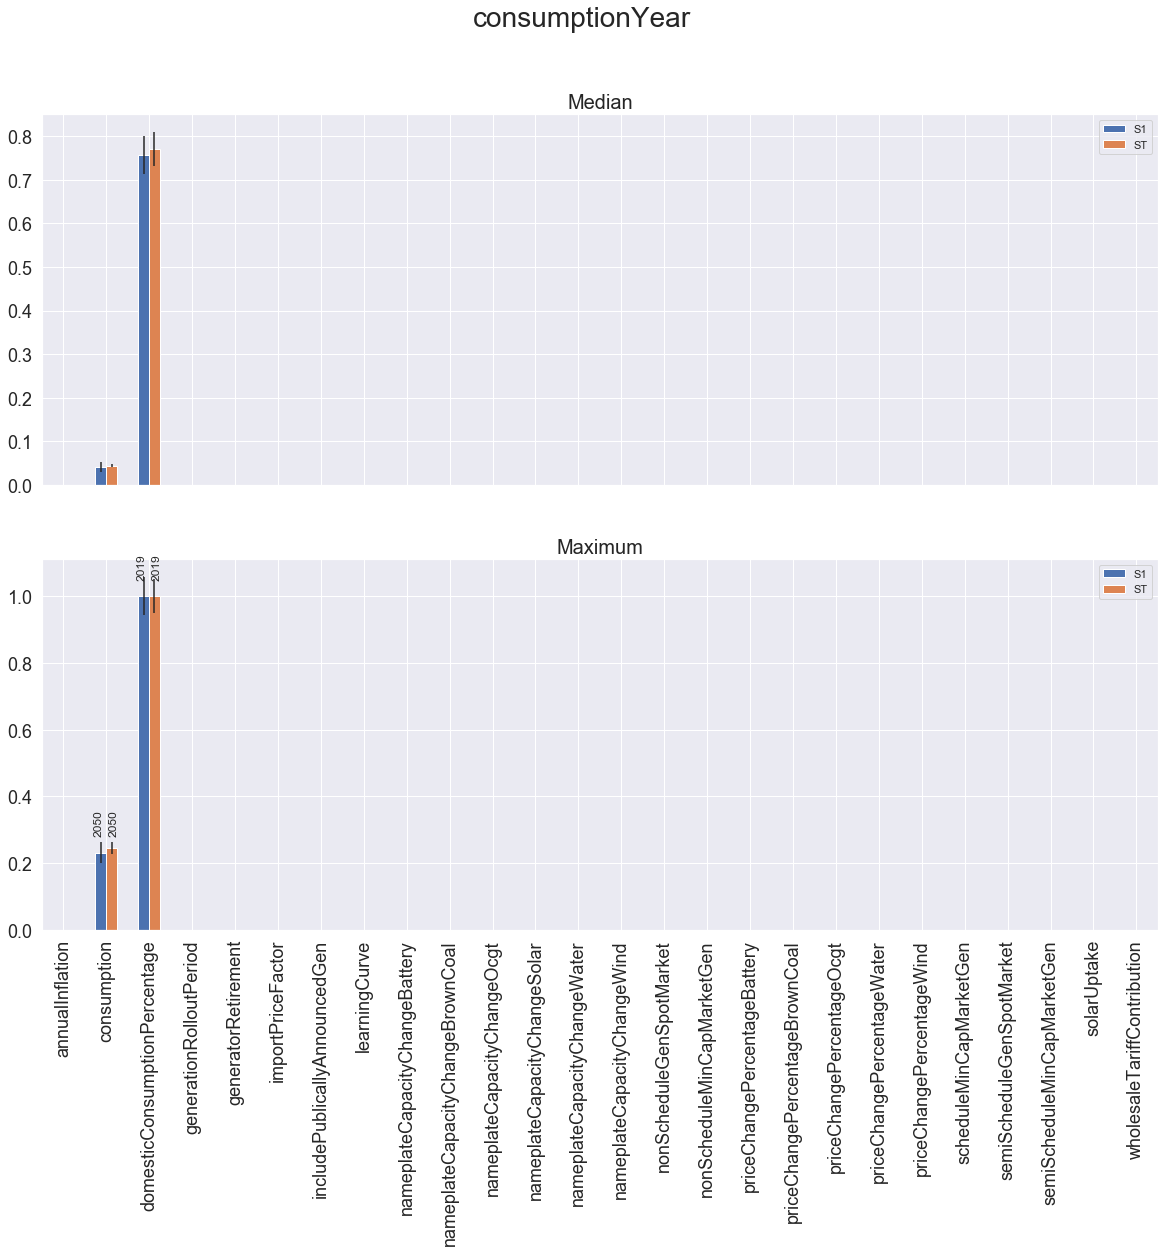

In [153]:
import seaborn as sns; sns.set()

writer = pd.ExcelWriter('{}/SOBOL_{}.xlsx'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\data', '_median_sensitivity_Indices'), engine='xlsxwriter')

#f = plt.figure(figsize=(20,30)) 
for ooi in outcomes_to_show:
    
    Si_df_median = pd.concat({'S1': s1_median_ooi[ooi],'ST': st_median_ooi[ooi], 'S2': s2_median_ooi[ooi],'S1_conf': s1_conf_median_ooi[ooi],'ST_conf': st_conf_median_ooi[ooi], 'S2_conf': s2_conf_median_ooi[ooi]}, axis=1)
    Si_df_max = pd.concat({'S1': s1_max_val_ooi[ooi],'ST': st_max_val_ooi[ooi], 'S2': s2_max_val_ooi[ooi],'S1_conf': s1_conf_max_val_ooi[ooi],'ST_conf': st_conf_max_val_ooi[ooi], 'S2_conf': s2_conf_max_val_ooi[ooi]}, axis=1)
    
    if includePlots:
        fig, ax = plt.subplots(2, sharex=True)
        fig.set_size_inches(20,15)
        fig.suptitle(ooi, fontsize=28)

        ax[0].set_title("Median", fontsize=20)
        ax[1].set_title("Maximum", fontsize=20)

        plt.xticks (fontsize = 18)
        plt.yticks (fontsize = 18)
        ax[0].tick_params(labelsize=18)

        indices_median = Si_df_median[['S1','ST']]
        err_median = Si_df_median[['S1_conf','ST_conf']]

        indices_max = Si_df_max[['S1','ST']]
        err_max = Si_df_max[['S1_conf','ST_conf']]

        
        indices_median.plot.bar(yerr=err_median.values.T,ax=ax[0])
        indices_max.plot.bar(yerr=err_max.values.T,ax=ax[1])
        for p, text_s1, text_st in zip(ax[1].patches, s1_max_val_year_ooi[ooi], st_max_val_year_ooi[ooi]):
            if p.get_height() != 0:
                ax[1].annotate(str(text_s1), (p.get_x() - 0.05, p.get_height() + .055) ,fontsize=12, rotation='vertical')
                ax[1].annotate(str(text_st), (p.get_x() + 0.3, p.get_height() + .055) ,fontsize=12,  rotation='vertical')
                               
        ax[0].legend(['S1','ST'])
        ax[1].legend(['S1','ST'])
        
        plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_barplot_s1_st_%s'%(ooi)),dpi=300, bbox_inches='tight')
        
    print(ooi)
    
    if ooi == 'secondaryMaxUnmetDemandMwhPerHour':
        ooi = 'secondMaxUnmetMwhPerHour'
        
    Si_df_median.to_excel(writer, sheet_name=ooi)

    
    #break

writer.save()

### S2, S1, and ST plots

In [98]:
# #%matplotlib inline
# sns.set_style('whitegrid')
# if includePlots:
#     for ooi in outcomes_to_show:

#         #Maximum
#         Si_df_max = {'S1': s1_max_val_ooi[ooi].to_numpy(),'S2': s2_max_val_ooi[ooi].to_numpy(),
#                      'ST': st_max_val_ooi[ooi].to_numpy(),'S1_conf': s1_conf_max_val_ooi[ooi].to_numpy(),
#                      'S2_conf': s2_conf_max_val_ooi[ooi].to_numpy(),'ST_conf': st_conf_max_val_ooi[ooi].to_numpy()}

#         fig = plot_sobol_indices(Si_df_max, uncertainties, criterion='ST', threshold=0.005)
#         fig.set_size_inches(20,15)
#         fig.suptitle(ooi)   

#         plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_sobol_max_%s'%(ooi)),dpi=300, bbox_inches='tight')

#         #Median
#         Si_df_avg = {'S1': s1_median_ooi[ooi].to_numpy(),'S2': s2_median_ooi[ooi].to_numpy(),
#                      'ST': st_median_ooi[ooi].to_numpy(),'S1_conf': s1_conf_median_ooi[ooi].to_numpy(),
#                      'S2_conf': s2_conf_median_ooi[ooi].to_numpy(),'ST_conf': st_conf_median_ooi[ooi].to_numpy()}

#         fig = plot_sobol_indices(Si_df_median, uncertainties, criterion='ST', threshold=0.005)
#         fig.set_size_inches(20,15)
#         fig.suptitle(ooi, fontsize=16)   



#         plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_sobol_median_%s'%(ooi)),dpi=300, bbox_inches='tight')

#         print(ooi)
     

## Boxplot

In [ ]:
# for ooi in outcomes_to_show:
#     data = outcomes[ooi][:, startYearShift:]


# for n in uncertainties:
#     dfBoxPlot = pd.DataFrame(index = index, data = data.T,columns=[ experiments[n] ])
#     dfMeltdfBoxPlot = pd.melt(dfBoxPlot)
#      #dfMeltdfBoxPlot.rename(columns={"value":ooi})

#     ax = dfMeltdfBoxPlot.boxplot(by=n, meanline=True, showmeans=False, showcaps=True, 
#                      showbox=True, showfliers=False, return_type='axes', figsize=(15, 10))


#     plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_sobol_boxplots_%s_%s'%(ooi,n)), 
#                   dpi=300, bbox_inches='tight')


#     plt.show()
#     plt.close()
 


C:\Users\angel\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


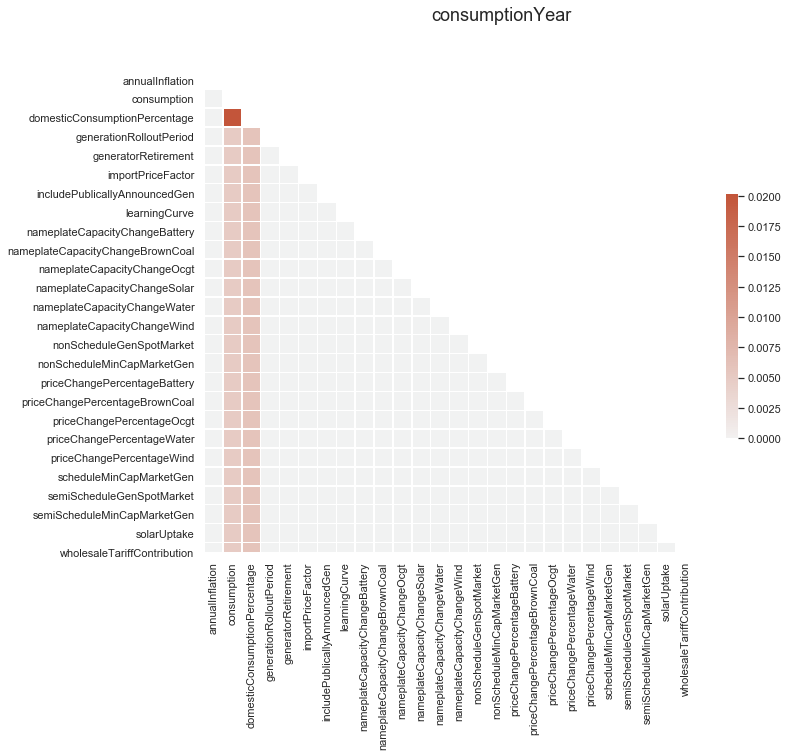

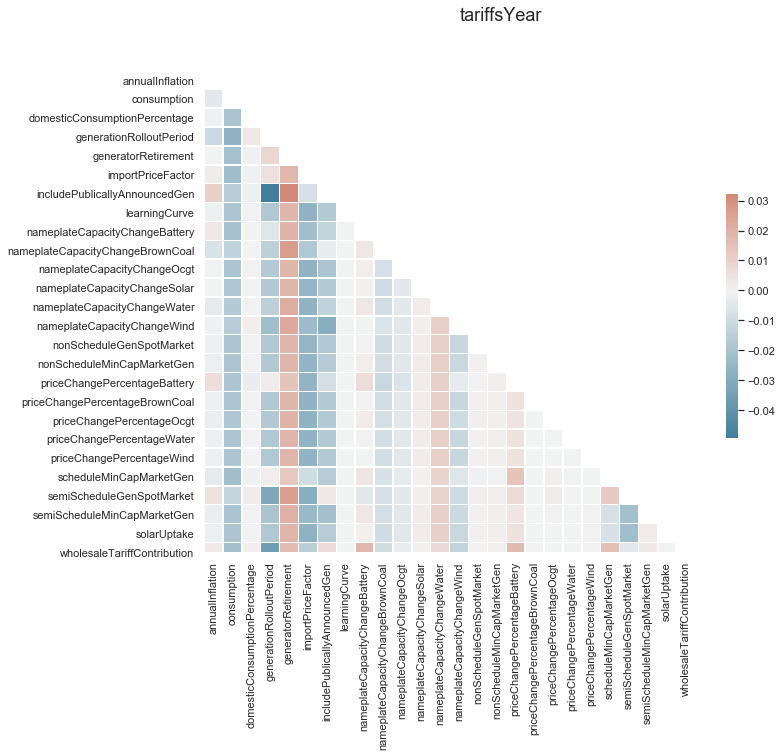

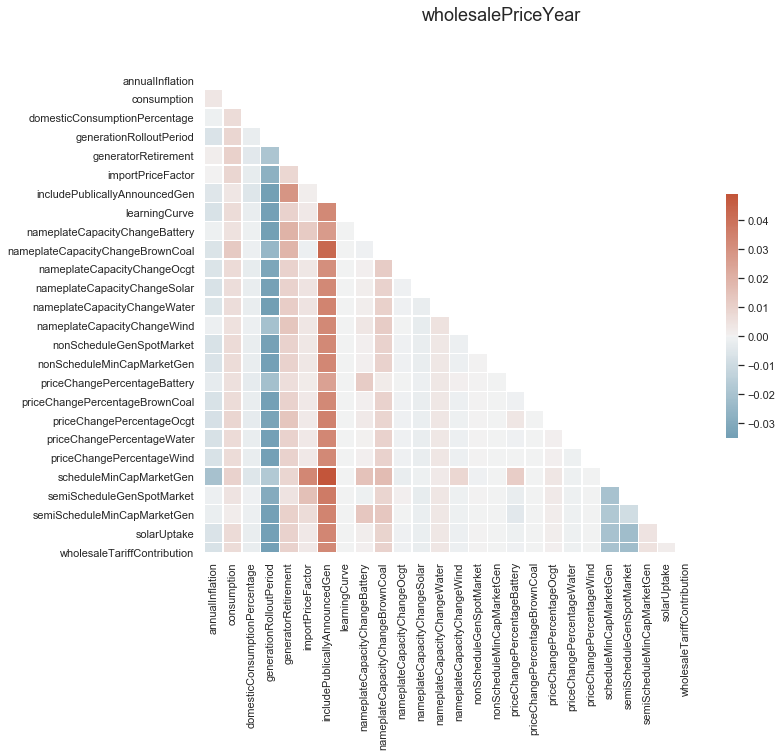

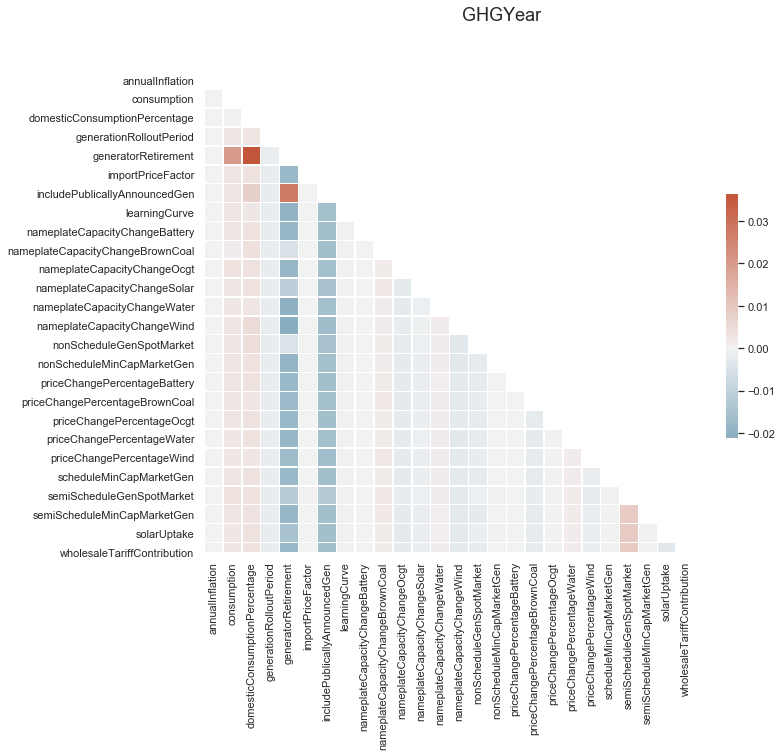

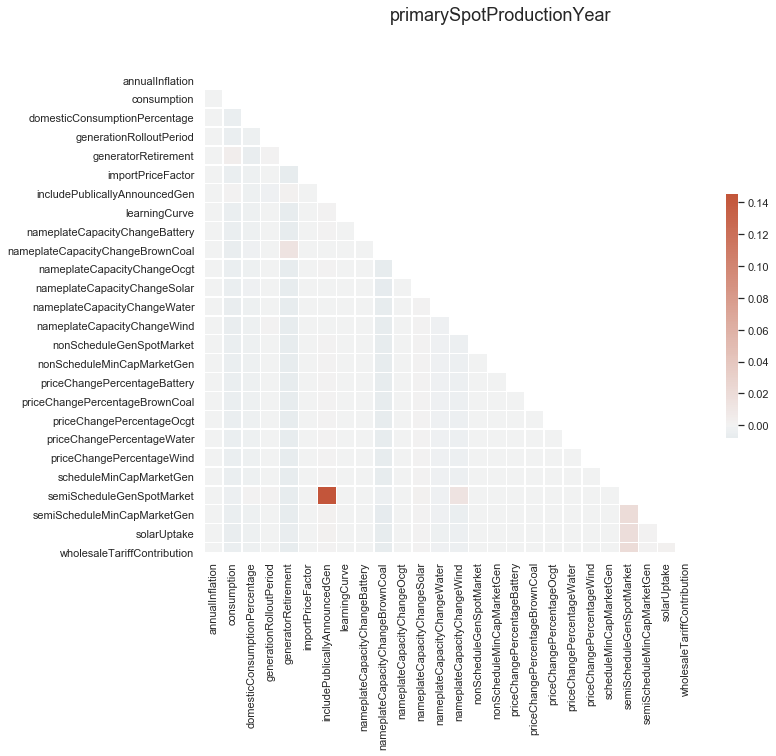

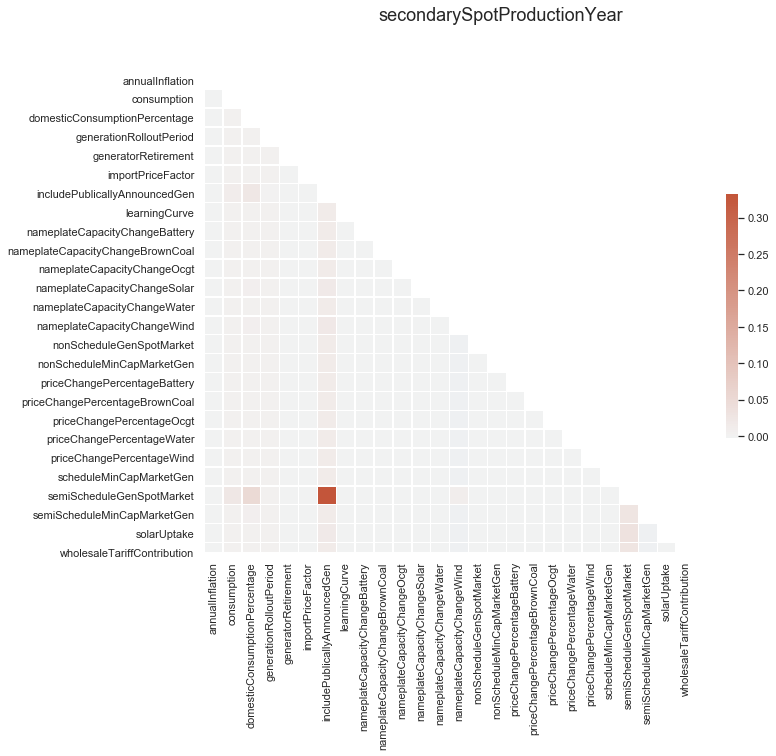

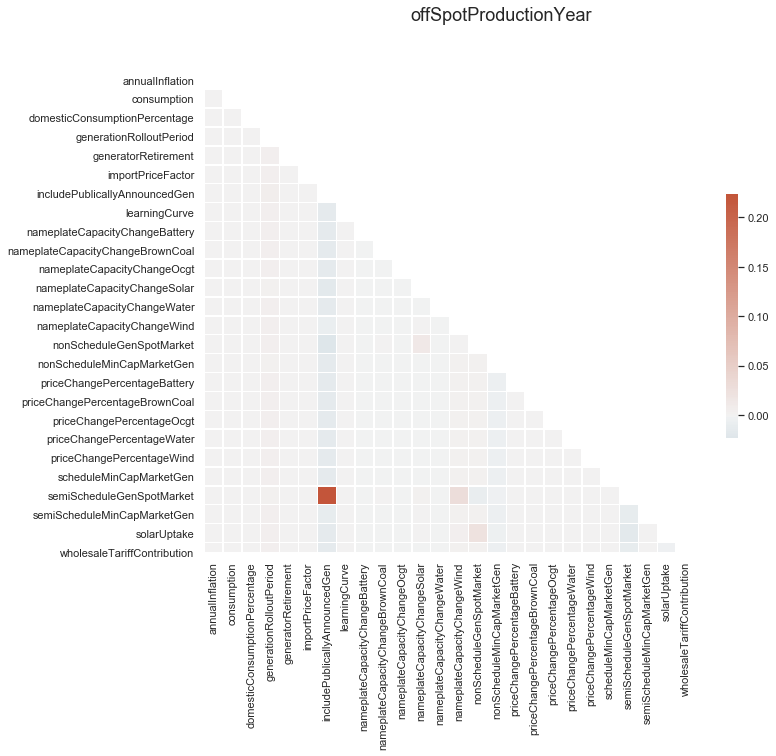

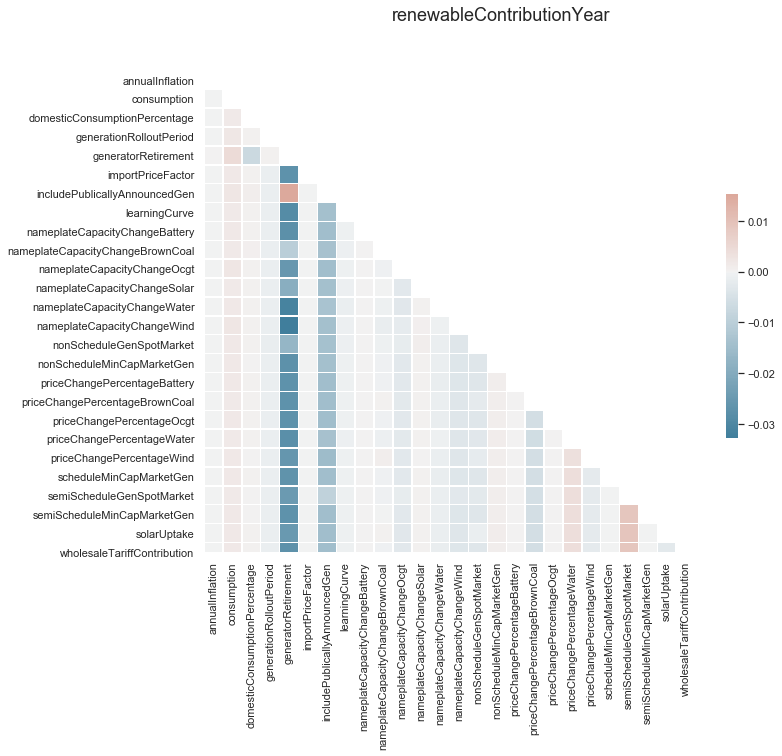

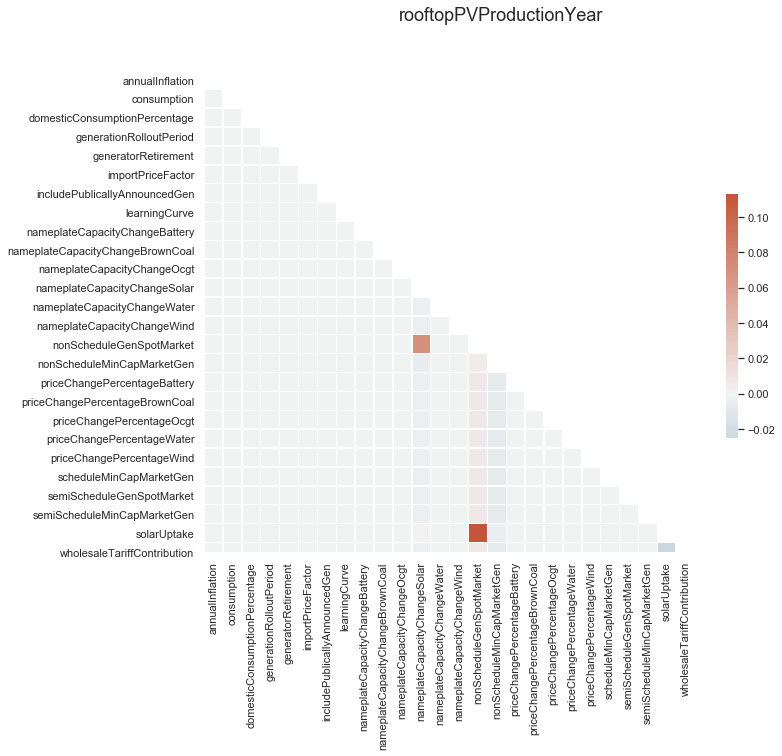

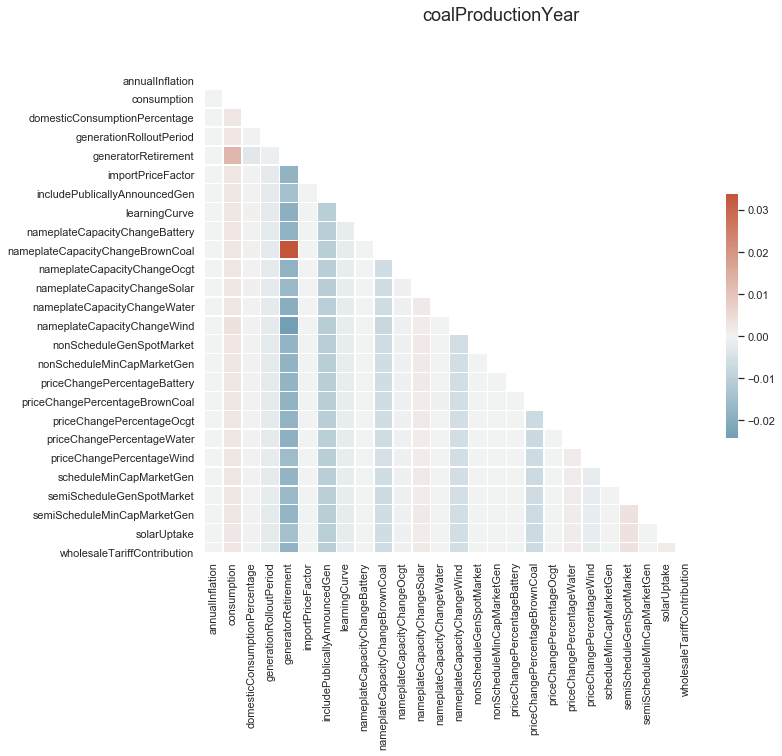

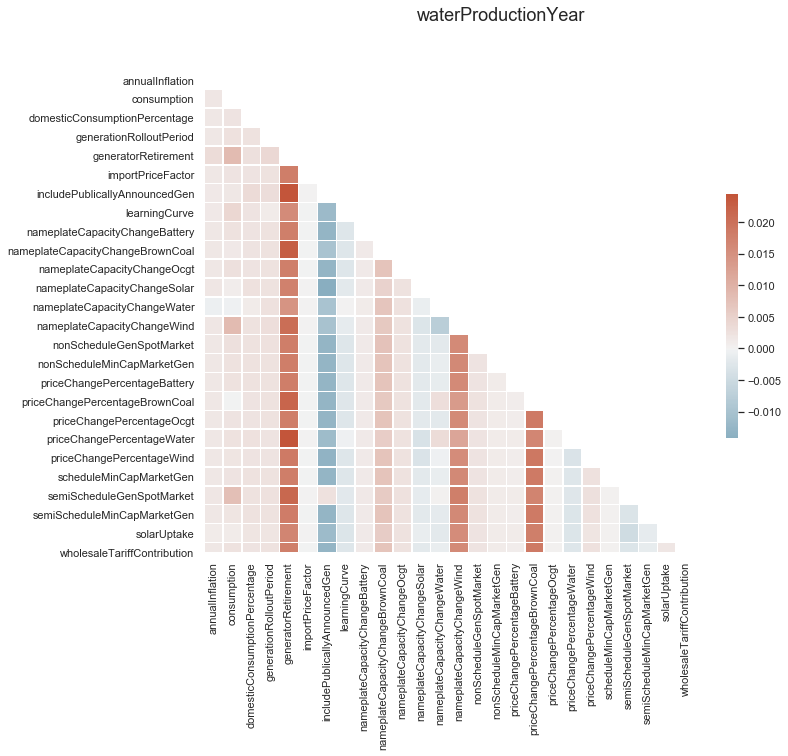

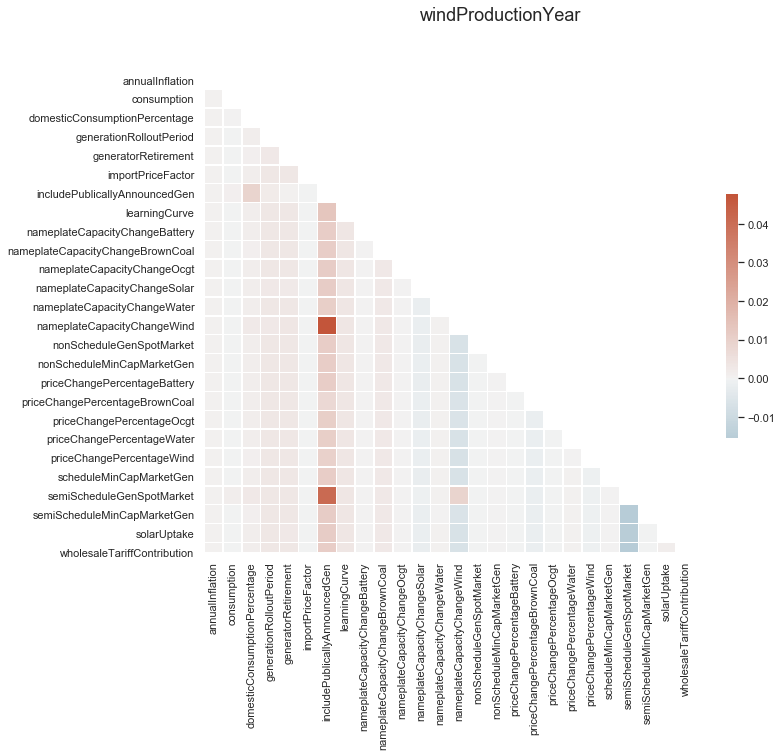

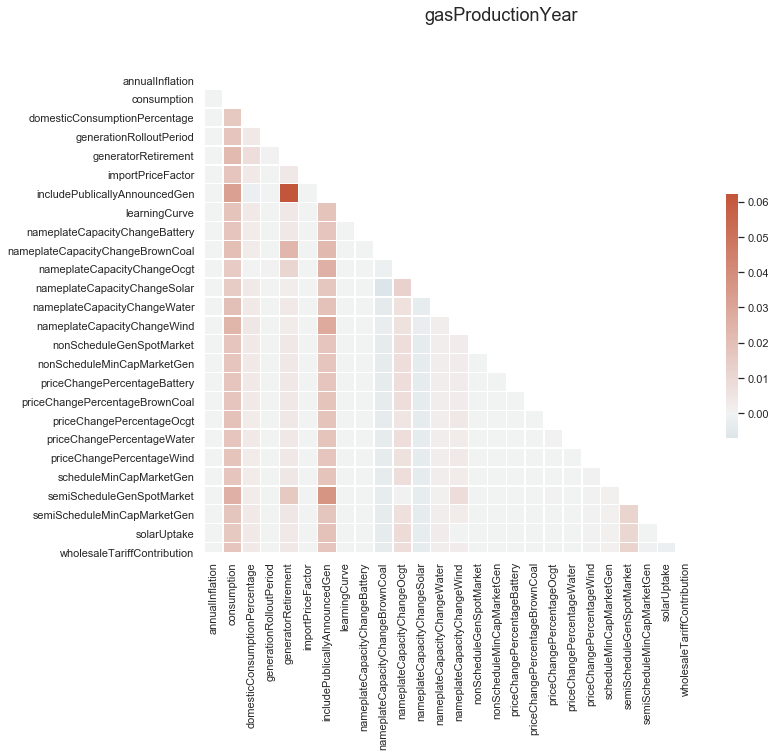

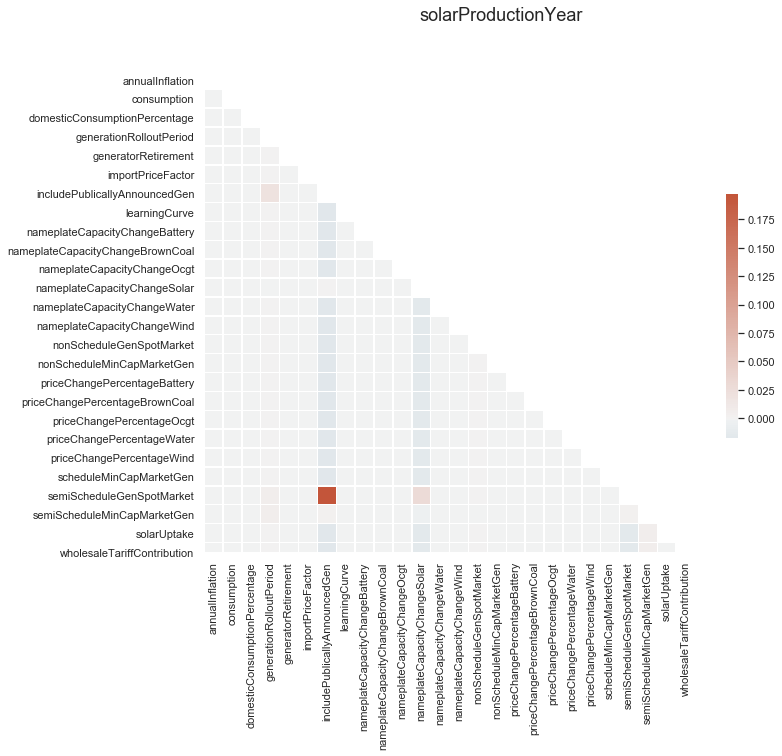

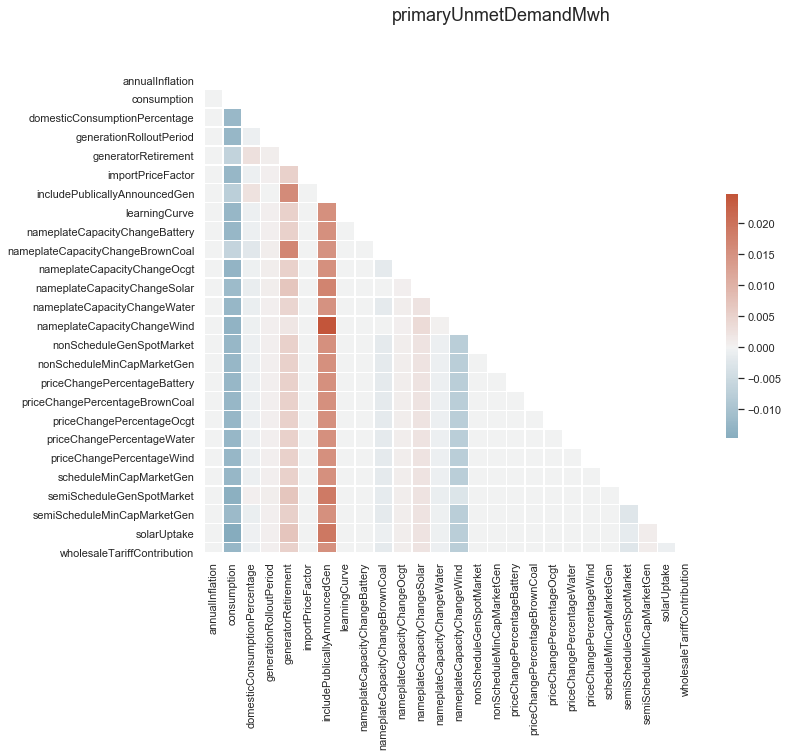

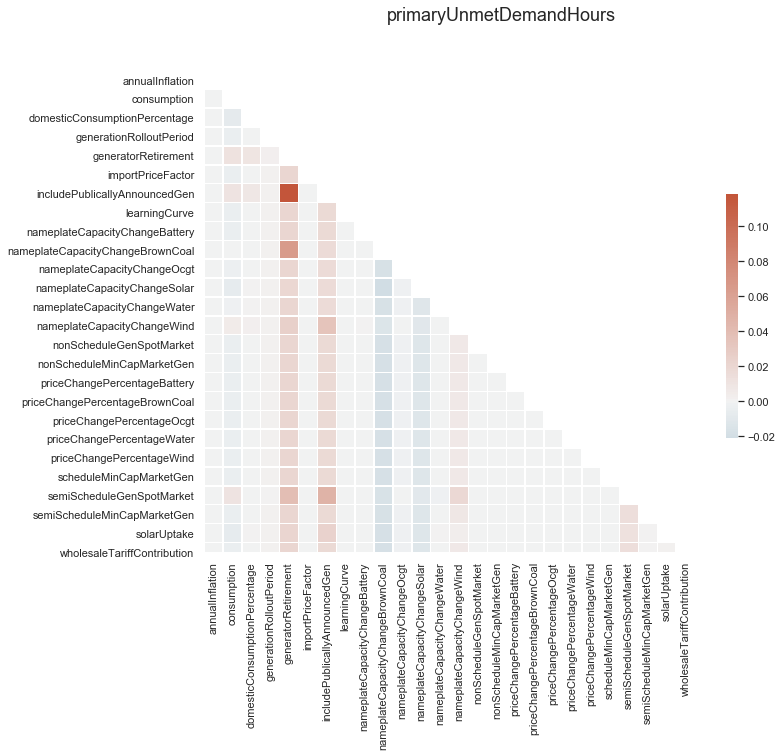

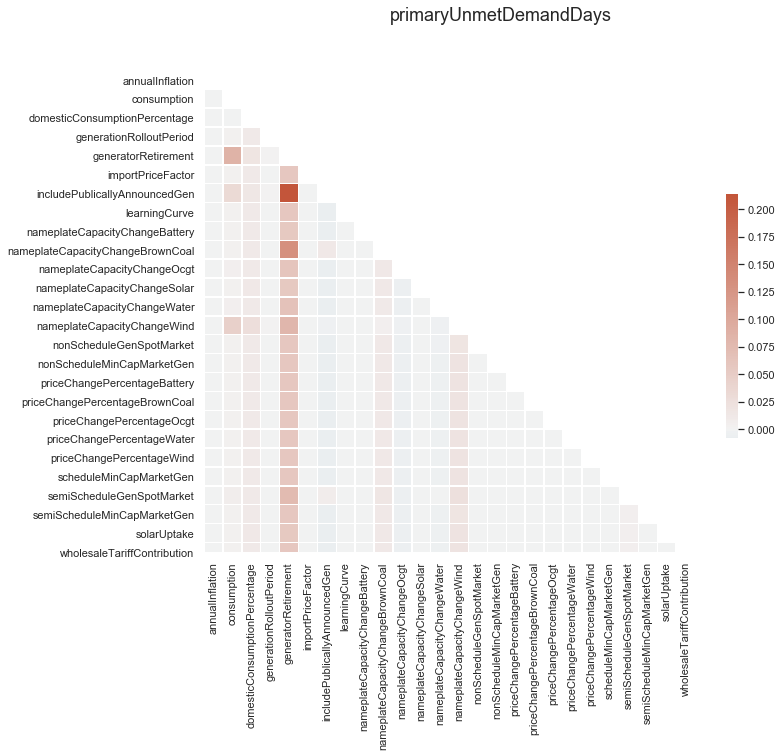

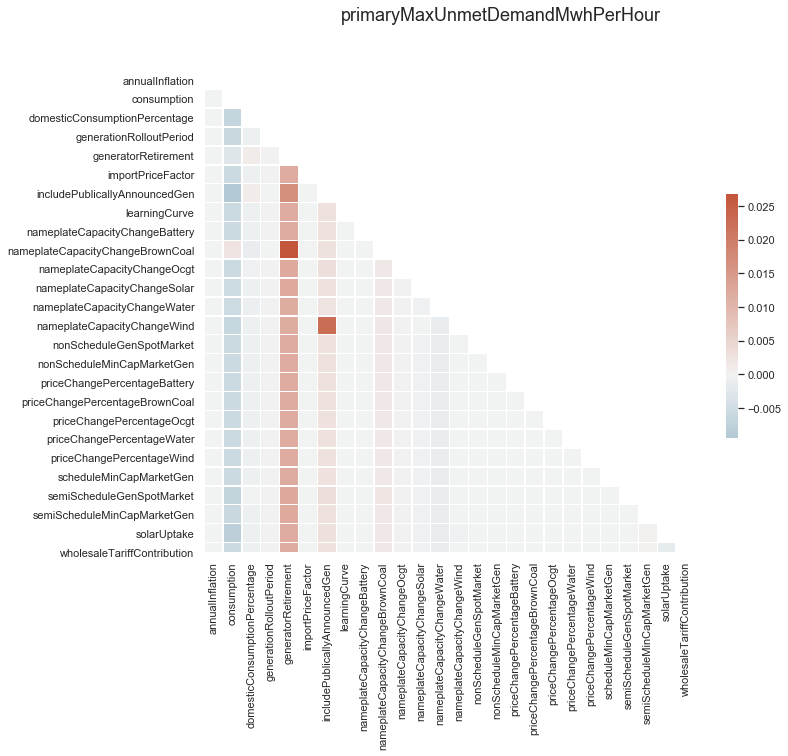

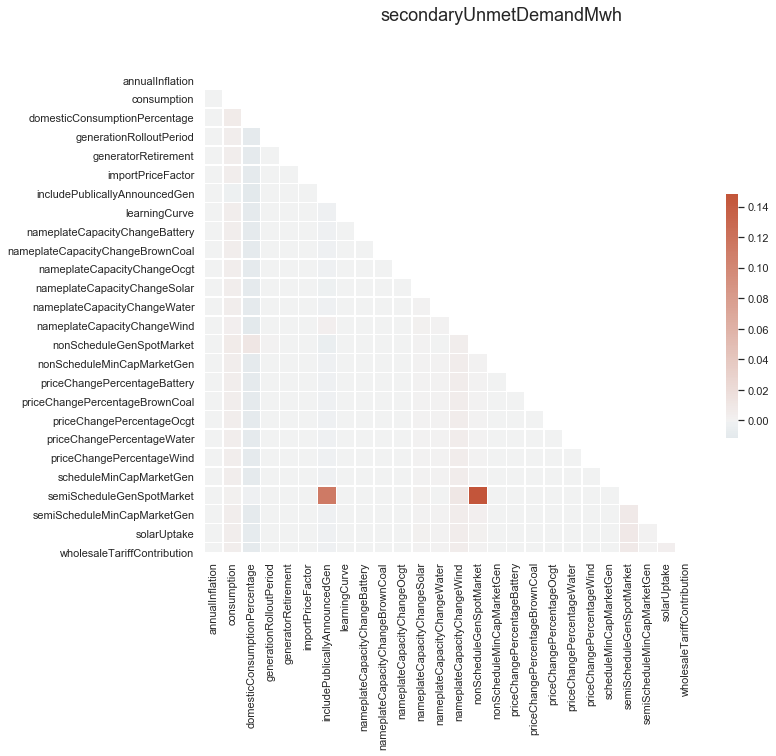

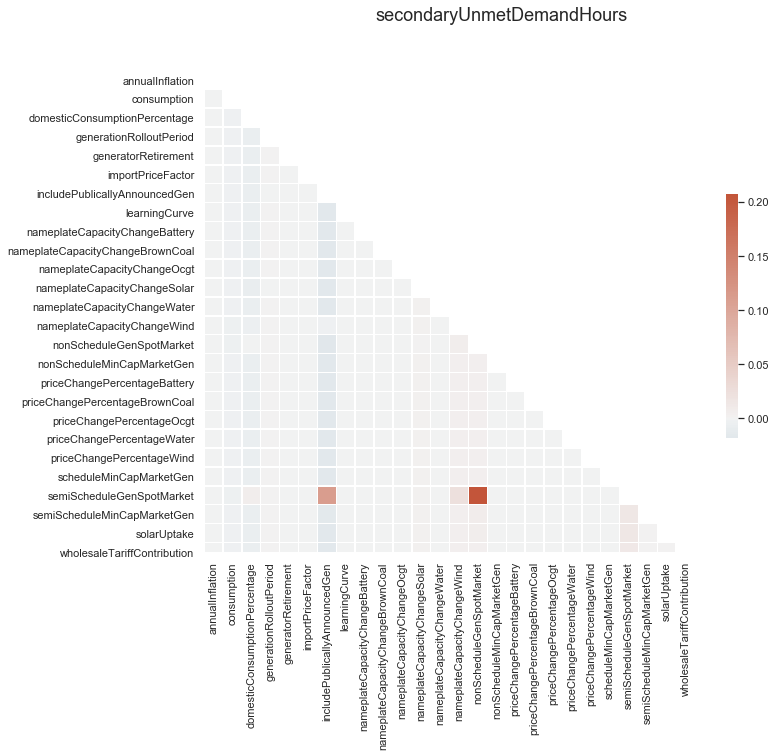

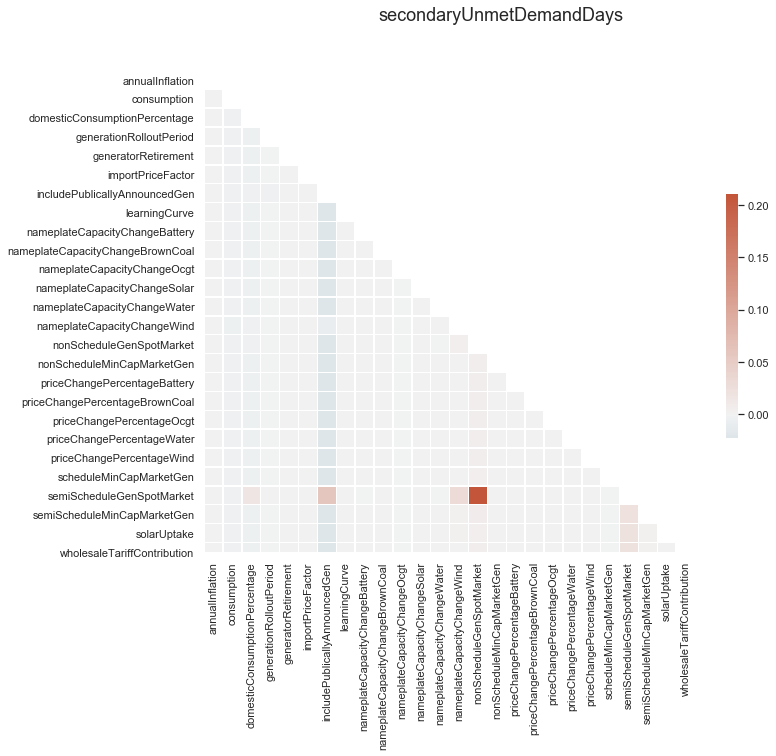

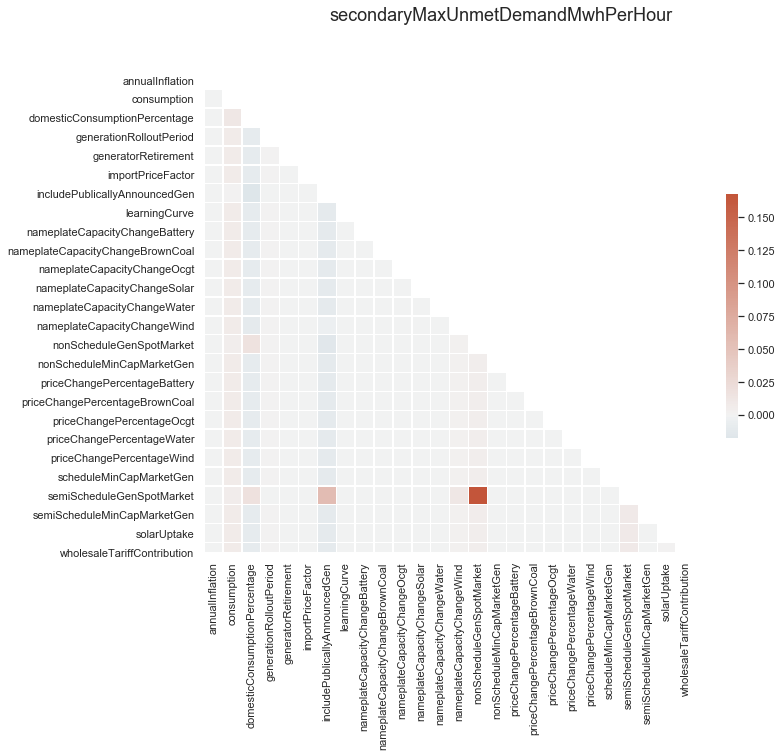

In [99]:
includePlots=True
if includePlots:
    for ooi in outcomes_to_show:
        corr = s2_median_ooi[ooi]

        # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=(11, 9))

        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(230, 20, as_cmap=True)

        # Draw the heatmap
        sns.heatmap(corr.T, cmap=cmap, vmin=corr.min(axis=1).min(),vmax=corr.max(axis=1).max(), center=0,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5})
        f.suptitle(ooi, fontsize=18)
        plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_sobol_s2_median_%s'%(ooi)),dpi=300, bbox_inches='tight')

